In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

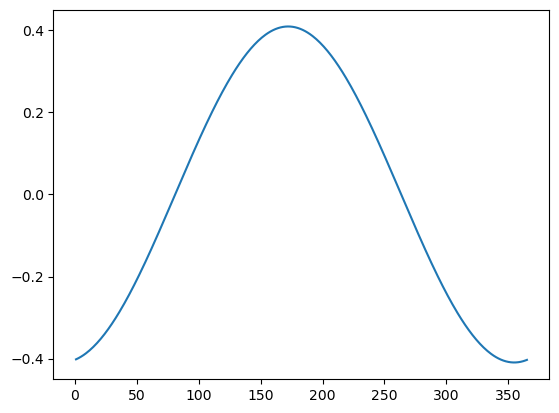

In [3]:
N = np.arange(1, 366, 1)

delta = (23.45 * np.sin(
        (360/365 * (284 + N)) / 360 * 2 * np.pi
        )) / 360 * 2 * np.pi

plt.plot(N, delta)

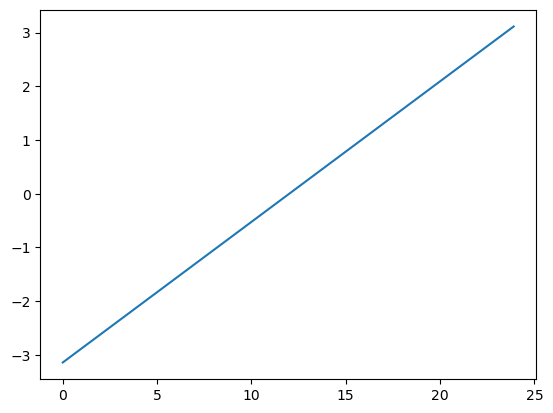

In [5]:
local_hour_of_day = np.arange(0, 24, 0.1)

h = (((local_hour_of_day - 12) % 24)/24) * 2 * np.pi

mask = np.nonzero(h>=np.pi)

h[mask] = -((2*np.pi)-h[mask])

plt.plot(local_hour_of_day, h)

In [211]:
# timestamps = pd.date_range('2023-01-01', '2023-01-05', freq='1h')
# timestamps = pd.date_range('2023-07-01', '2023-07-05', freq='1h')
timestamps = pd.date_range('2023-01-01', '2024-01-01', freq='1h')


print(len(timestamps))


8761


In [218]:
latitude = 70  # degrees
surface_azimuth_angle = -(88 + 90) / 360 * 2 * np.pi
angle = 0

Method 1 (file:///C:/Users/bruij_kn/Downloads/7.1_Solar_Radiation_on_Inclined_Surfaces%20(1).pdf)

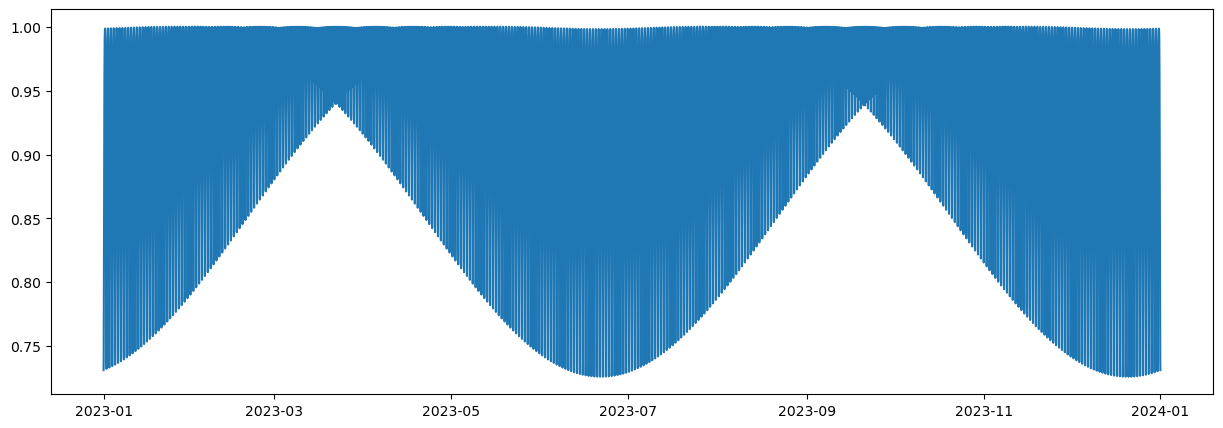

In [219]:
beta = angle / 360 * 2 * np.pi

# latitude
phi = latitude / 360 * 2 * np.pi

# declination, Sarbu (2017)
delta = (23.45 * np.sin(
    (360/365 * (284 + timestamps.dayofyear.values)) / 360 * 2 * np.pi
    )) / 360 * 2 * np.pi

# hour angle, for Alaska timezone difference w.r.t. UTC is -8h
local_hour_of_day = timestamps.hour.values #+ timezone_diff
# convert to hour angle
h = (((local_hour_of_day - 12) % 24)/24) * 2 * np.pi
mask = np.nonzero(h>=np.pi)
h[mask] = -((2 * np.pi) - h[mask])

# solar altitude
a = np.arcsin(np.cos(phi) * np.cos(delta) * np.cos(h) + np.sin(phi) * np.sin(delta))

value = ((np.sin(a) * np.sin(phi) - np.sin(delta)) / (np.cos(a) * np.cos(phi)))

mask_pos = np.nonzero(value>1)
value[mask_pos] = 1

mask_neg = np.nonzero(value<-1)
value[mask_neg] = -1

solar_azimuth = np.arccos(value) * np.sign(h)

gamma = solar_azimuth - surface_azimuth_angle
gamma_mask = np.nonzero((gamma>1/2*np.pi) * (gamma<3/2*np.pi) + (gamma>-3/2*np.pi) * (gamma<-1/2*np.pi))
gamma[gamma_mask] = 0

theta = np.arccos(np.cos(a) * np.cos(np.abs(gamma)) * np.sin(beta) + np.sin(a) * np.cos(beta))

factor = np.sin(theta)

plt.figure(figsize=(15,5))

plt.plot(timestamps, factor)

plt.show()

plt.close()


Method 2: “Central Beaufort Sea Wave and Hydrodynamic Modeling Study Report 1: Field Measurements and Model Development,” n.d.

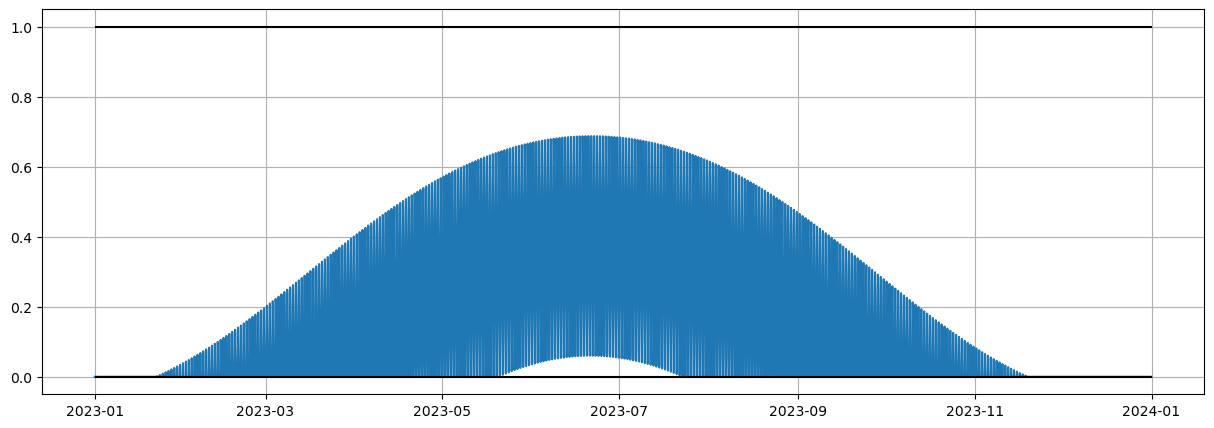

In [220]:
# latitude
phi = latitude / 360 * 2 * np.pi
alpha = angle / 360 * 2 * np.pi

# declination, Sarbu (2017)
delta = (23.45 * np.sin(
    (360/365 * (284 + timestamps.dayofyear.values)) / 360 * 2 * np.pi
    )) / 360 * 2 * np.pi

# hour angle, for Alaska timezone difference w.r.t. UTC is -8h
local_hour_of_day = timestamps.hour.values #+ timezone_diff
# convert to hour angle
h = (((local_hour_of_day - 12) % 24)/24) * 2 * np.pi
mask = np.nonzero(h>=np.pi)
h[mask] = -((2 * np.pi) - h[mask])

A = np.arcsin(np.sin(phi) * np.sin(delta) + np.cos(phi) * np.cos(delta) * np.cos(h))

AZ = np.cos(delta) * (np.sin(h)) / np.cos(A)

ew_AM_mask = np.nonzero((np.cos(h) > np.tan(delta) / np.tan(phi)) + (local_hour_of_day <= 12))  # east-west AM mask
ew_PM_mask = np.nonzero((np.cos(h) > np.tan(delta) / np.tan(phi)) + (local_hour_of_day > 12)) # east-west PM mask

AZ[ew_AM_mask] = -np.pi + np.abs(AZ[ew_AM_mask])
AZ[ew_PM_mask] = np.pi - np.abs(AZ[ew_PM_mask])

Z = np.arcsin(np.cos(delta) * np.sin(h) / np.cos(A)) + 1/2 * np.pi

sin_theta = np.sin(A) * np.cos(alpha) - np.cos(A) * np.sin(alpha) * np.sin(Z - 2/360 * 2 * np.pi)
sin_theta[np.nonzero(sin_theta>1)] = 1
sin_theta[np.nonzero(sin_theta<0)] = 0

theta = np.arcsin(sin_theta)

# zero_mask = np.nonzero(sin_theta <= 0)

# sin_theta[zero_mask] = 0

plt.figure(figsize=(15,5))

plt.plot(timestamps, sin_theta)

plt.hlines([0, 1], xmin = np.min(timestamps), xmax = np.max(timestamps), color='k')

plt.grid(visible=True, which='both', rasterized=True)

plt.show()

plt.close()

In [221]:
import xarray as xr

In [231]:
ds = xr.open_dataset("mean_surface_net_short_wave_radiation_flux_2020.nc")

ds_masked = ds.where((ds.longitude==190.0) & (ds.latitude==75.0), drop=True)

ds.close()

print(ds_masked)

<xarray.Dataset> Size: 141kB
Dimensions:    (time: 8784, latitude: 1, longitude: 1)
Coordinates:
  * longitude  (longitude) float32 4B 190.0
  * latitude   (latitude) float32 4B 75.0
  * time       (time) datetime64[ns] 70kB 2020-01-01 ... 2020-12-31T23:00:00
Data variables:
    msnswrf    (time, latitude, longitude) float64 70kB 0.0 0.0 0.0 ... 0.0 0.0
Attributes:
    Conventions:  CF-1.6
    history:      2024-04-17 00:03:41 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...


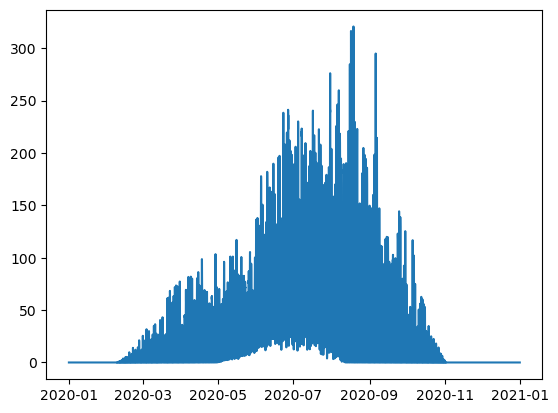

In [234]:
plt.plot(ds_masked.time.values, ds_masked.msnswrf.values.flatten())

In [235]:
x = np.linspace(0, 10, 10)
y = -np.sqrt(x)

np.gradient(y, x)

array([-0.9486833 , -0.67082039, -0.34724219, -0.2778629 , -0.23907634,
       -0.21321171, -0.19432987, -0.17974578, -0.16803491, -0.16276832])